# Test Pose Estimation using Faster-RCNN + HRNet

In [1]:
import os
import sys
import json
import collections
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import DataParallel
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

from data import StyledCoco
import models
from models.utils.config import opt
from CONFIG import CONFIG
import CONSTANTS
import data
from data.custom_transforms import Normalize, Resize
import data.data_processing as data_processing
import lib.arguments as arguments
import lib.utils as utils
import lib.metrics as metrics
import lib.loss as loss
import lib.inference as inference
import lib.bounding_box as bbox
import lib.pose_parsing as pose_parsing 
import lib.visualizations as visualizations


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

In [4]:
COCO_KEYPOINT_INDEXES = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}

# Dataset

In [5]:
image_size = 600
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["training"]["batch_size"] = 2
exp_data["dataset"]["dataset_name"] = "coco"
exp_data["dataset"]["image_size"] = image_size
exp_data["model"]["model_name"] = "HRNet"

In [6]:
_, valid_loader = data.load_dataset(exp_data=exp_data, train=False,
                                    validation=True, shuffle_train=True,
                                    shuffle_valid=False)

_, random_loader, _, dataset = data.load_dataset(exp_data=exp_data, train=False,
                                                 validation=True, shuffle_train=True,
                                                 shuffle_valid=True, get_dataset=True)



loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


### Loading images manually

In [7]:
img_name_1, img_name_2 = "vase1.jpg", "vase3.png"
img_path_1 = os.path.join(os.getcwd(), "resources", img_name_1)
img_path_2 = os.path.join(os.getcwd(), "resources", img_name_2)

img1 = cv2.imread(img_path_1, cv2.IMREAD_COLOR)
img2 = cv2.imread(img_path_2, cv2.IMREAD_COLOR)

In [8]:
normalizer = Normalize(mean=(128, 128, 128), std=256)
img1 = normalizer(img1)
img2 = normalizer(img2)

resizer = Resize(size=600)
img1 = resizer(img1)
img2 = resizer(img2)

In [9]:
imgs = np.array([img1, img2])
imgs = imgs.transpose(0,3,1,2)
imgs = torch.Tensor(imgs)

# Model

In [10]:
# Human Detection
# faster_rcnn = models.FasterRCNN()
# pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "FasterRCNN", "chainer_best_model_converted_to_pytorch_0.7053.pth")
# faster_rcnn = faster_rcnn.load_pretrained(pretrained_path)

faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
faster_rcnn = faster_rcnn.to(device)
hrnet = hrnet.to(device)
faster_rcnn = faster_rcnn.eval()
hrnet = hrnet.eval()

# Inference

In [13]:
iterator = iter(valid_loader)
# for i in range(1):
#     imgs, heatmaps, pafs, mask, metadata = iterator.next()

imgs, heatmaps, pafs, mask, metadata = iter(random_loader).next()
# imgs, heatmaps, pafs, mask, metadata = iter(valid_loader).next()

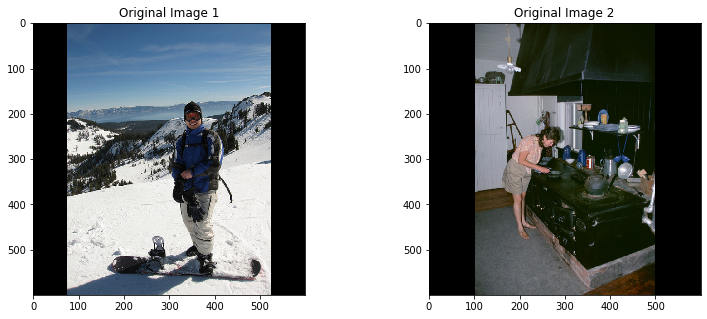

In [14]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(13, 5)
visualizations.visualize_image(np.array(imgs[0,:]), ax=ax[0], title="Original Image 1")
visualizations.visualize_image(np.array(imgs[1,:]), ax=ax[1], title="Original Image 2")

In [15]:
imgs_f = imgs  #*256 + 128
# bboxes, labels, scores = faster_rcnn.predict(imgs_f, visualize=True)
predictions = faster_rcnn(imgs_f.to(device).float()) 
all_scores = [p["scores"] for p in predictions]
all_labels = [p["labels"] for p in predictions]
bboxes, labels, scores = bbox.bbox_filtering(predictions, filter=1)

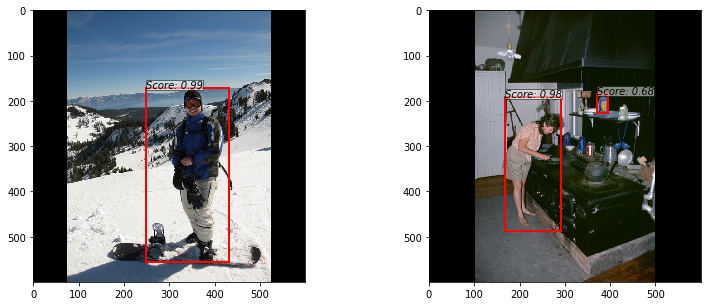

In [16]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(13, 5)
visualizations.visualize_bbox(np.array(imgs[0,:]), bbox=bboxes[0], label=labels[0], score=scores[0], ax=ax[0])
visualizations.visualize_bbox(np.array(imgs[1,:]), bbox=bboxes[1], label=labels[1], score=scores[1], ax=ax[1])
plt.show()

In [17]:
detections = bbox.get_detections(imgs, bboxes)
dets_per_img = [0] + [len(bb) for bb in bboxes]
N = len(detections)

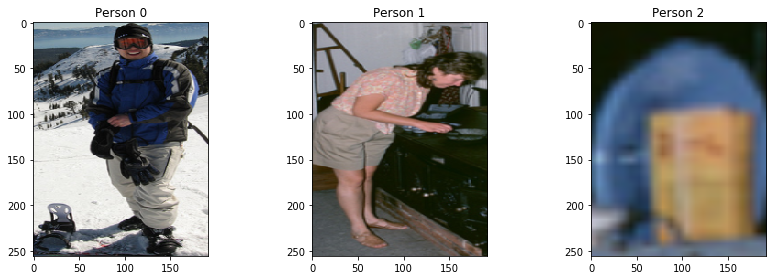

In [18]:
fig, ax = plt.subplots(1, N)
fig.set_size_inches(4*N,4)
for i in range(N):
    if(N > 1):
        visualizations.visualize_image(np.array(detections[i,:].cpu()), ax=ax[i], title=f"Person {i}")
    else:
        visualizations.visualize_image(np.array(detections[i,:].cpu()), ax=ax, title=f"Person {i}")
plt.tight_layout()
plt.show()

In [19]:
# scales = [1.0]
scales = [0.5, 1.0, 1.5, 2.0]

In [20]:
scaled_heats, pred_bboxes = inference.multiscale_inference_hrnet(hrnet, imgs, scales, image_size=(256, 192), device=device,
                                                                 model_name="HRNet", detector=faster_rcnn)


In [21]:
# predicted_heats = hrnet(detections.to(device).float())
# scaled_heats = F.interpolate(predicted_heats.clone().detach(), (256,192), mode="bilinear", align_corners=True).to(device)

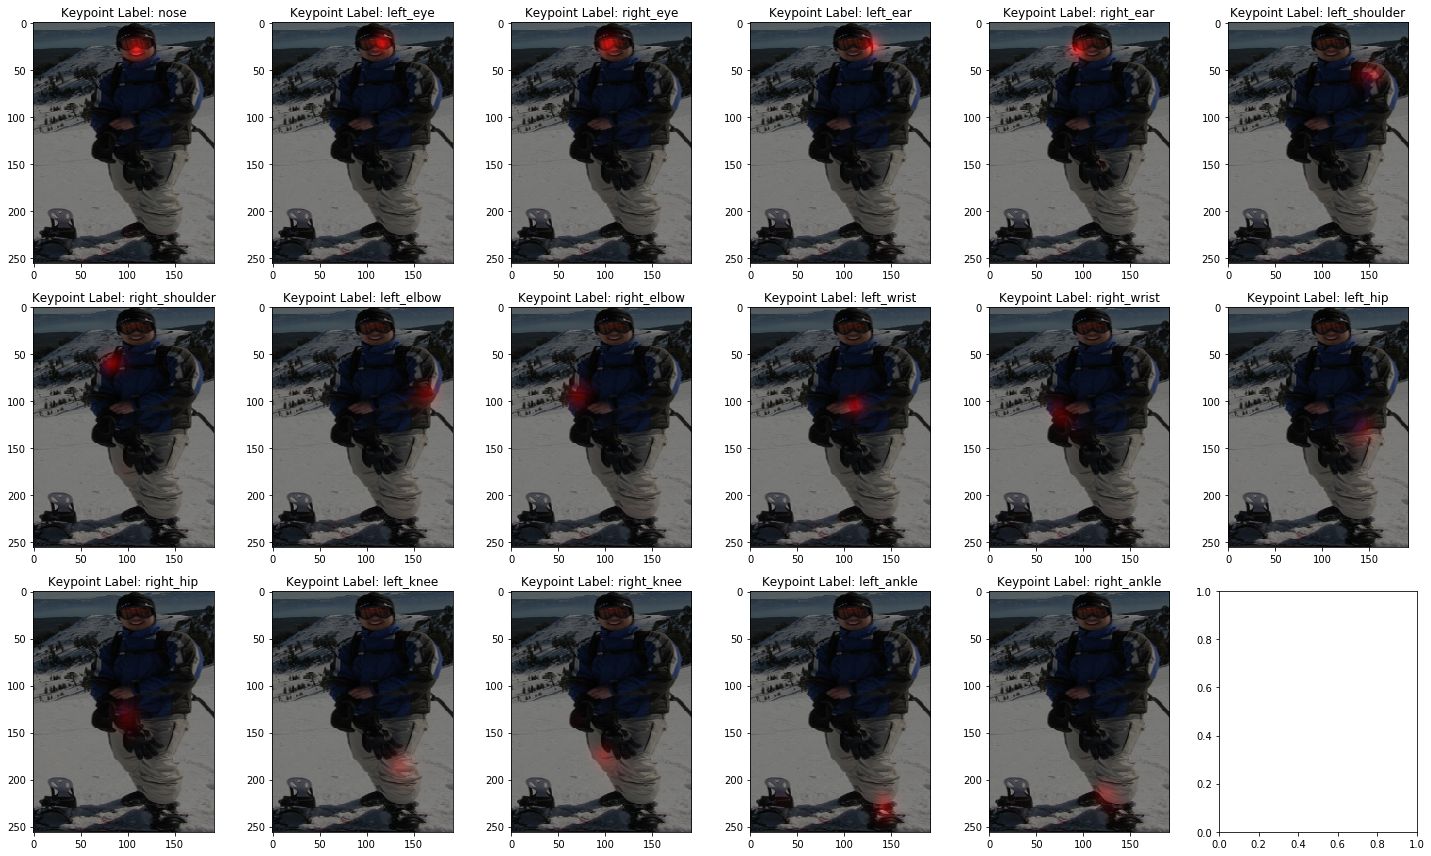

In [22]:
idx = 0
fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)
for i in range(17):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {COCO_KEYPOINT_INDEXES[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(scaled_heats[idx,i,:].cpu()), img=np.array(detections[idx,:].cpu()),
                                   ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

In [23]:
keypoints, max_vals = pose_parsing.get_max_preds_hrnet(scaled_heats.cpu().numpy(), thr=0.1)

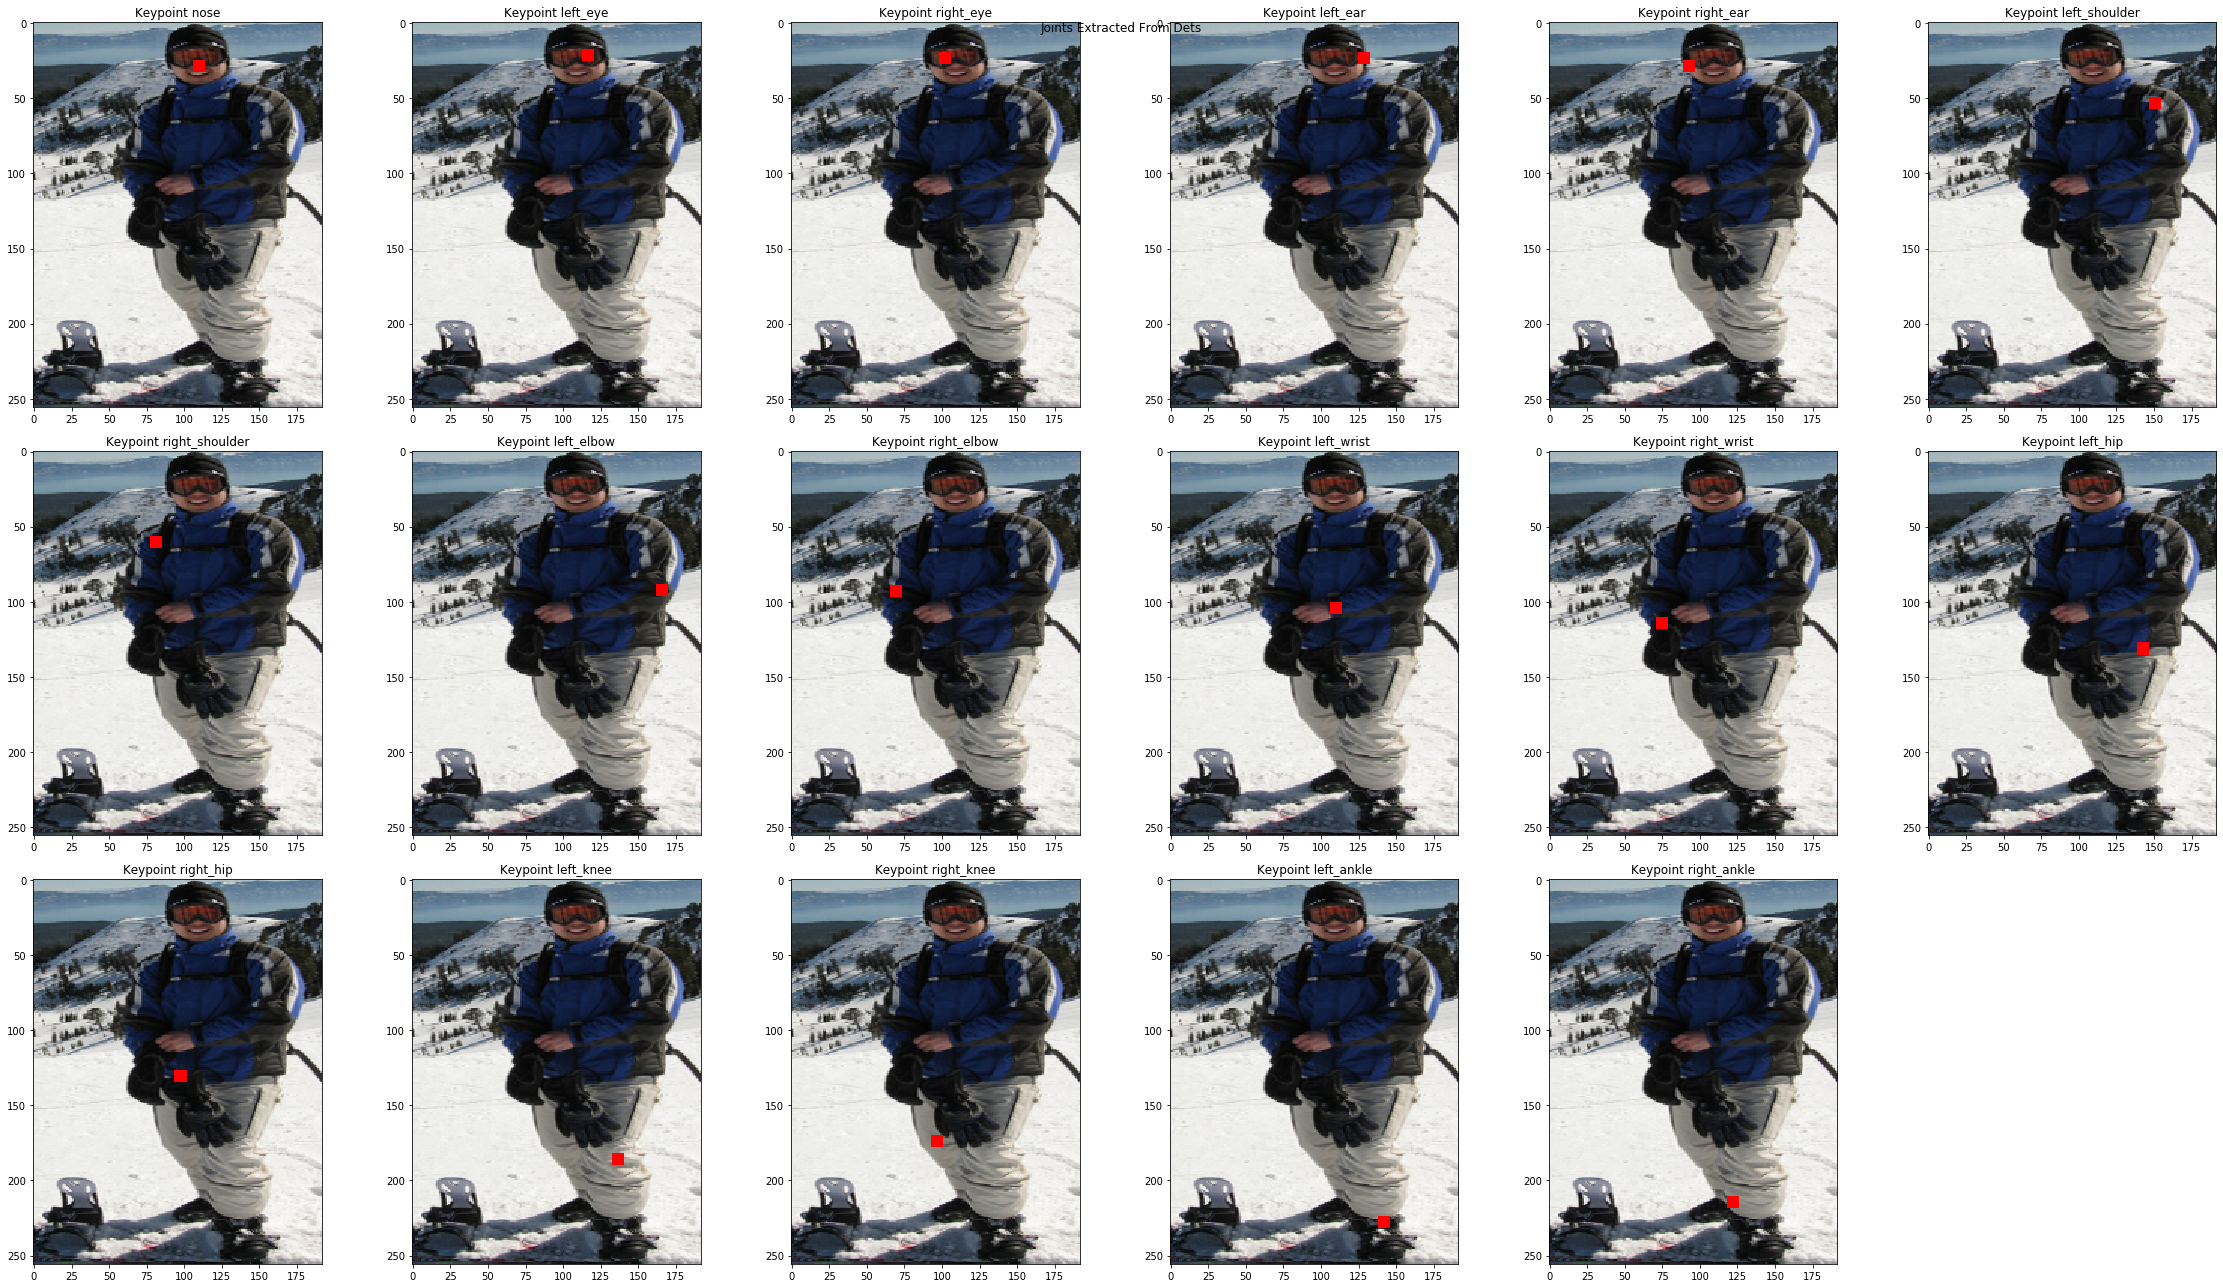

In [24]:
idx = 0
plt.figure(figsize=(32, 18))
zoom = 4

cur_img = np.array(detections[idx,:].cpu())
aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, k in enumerate(keypoints[idx]):
    
    aux = np.copy(aux_img)
    if(len(k) > 0):
        aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
        aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
        aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {COCO_KEYPOINT_INDEXES[i]}")
    
plt.suptitle("Joints Extracted From Dets")
plt.tight_layout()
plt.show()

In [25]:
reshaped_keypoints = bbox.bbox_to_image_keypoints(np.copy(keypoints), bboxes, height=256, width=192)
reshaped_keypoints_aux = [reshaped_keypoints[dets_per_img[i]:dets_per_img[i] + dets_per_img[i+1]] for i in range(len(dets_per_img[:-1]))]

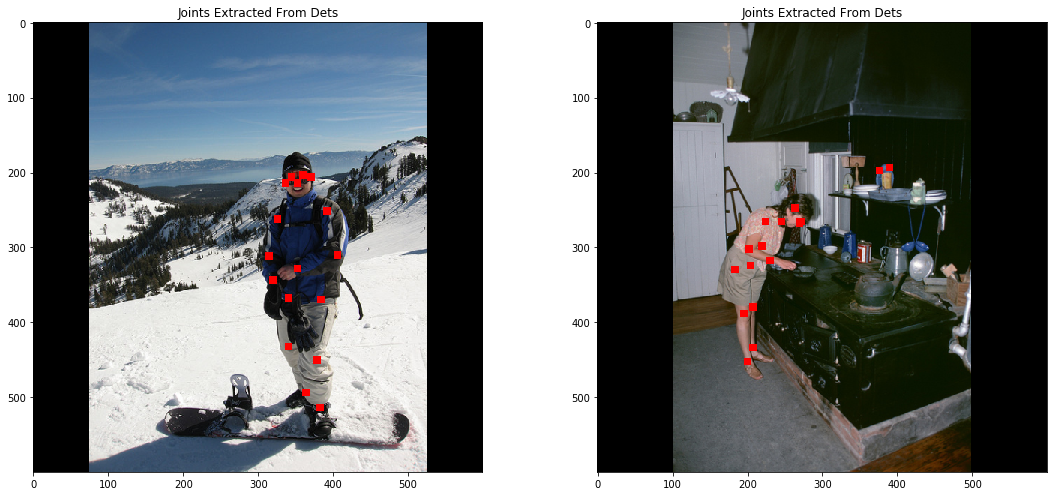

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,7)
zoom = 5

for idx in range(2):
    cur_img = np.array(imgs[idx,:].cpu())
    aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
    aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
    aux_img = np.round(aux_img).astype(int)

    aux = np.copy(aux_img)
    for i, bb in enumerate(reshaped_keypoints_aux[idx]):
        for j, k in enumerate(reshaped_keypoints_aux[idx][i]):
            if(len(k) > 0):
                aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
                aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
                aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    ax[idx].imshow(aux)
    ax[idx].set_title("Joints Extracted From Dets")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "resources", "keypoints_hrnet.png"))
plt.show()

In [27]:
pose_entries, all_keypoints = pose_parsing.create_pose_entries(reshaped_keypoints)
pose_entries = [pose_entries[dets_per_img[i]:dets_per_img[i] + dets_per_img[i+1]] for i in range(len(dets_per_img[:-1]))]

In [28]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

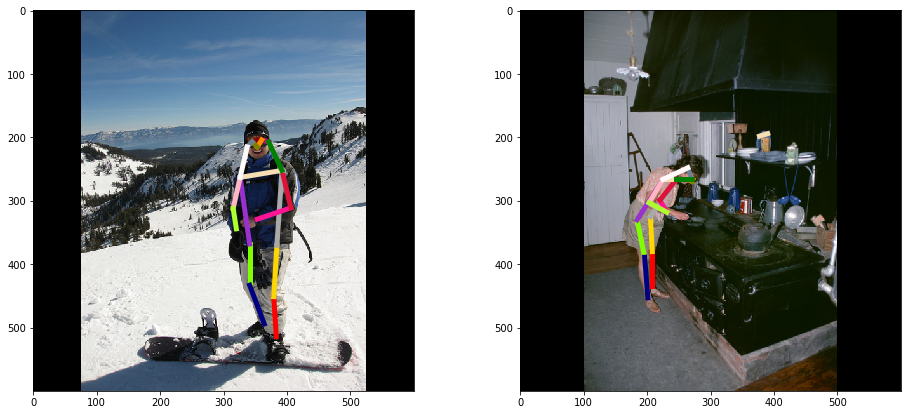

In [29]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,7)

title = "Pose from Detections"
visualizations.draw_pose(np.array(imgs[0,:]), pose_entries[0], all_keypoints, ax=ax[0], title=title)

title = "Pose from Detections"
visualizations.draw_pose(np.array(imgs[1,:]), pose_entries[1], all_keypoints, ax=ax[1], title=title)

plt.savefig(os.path.join(os.getcwd(), "resources", "skeletons_hrnet.png"))

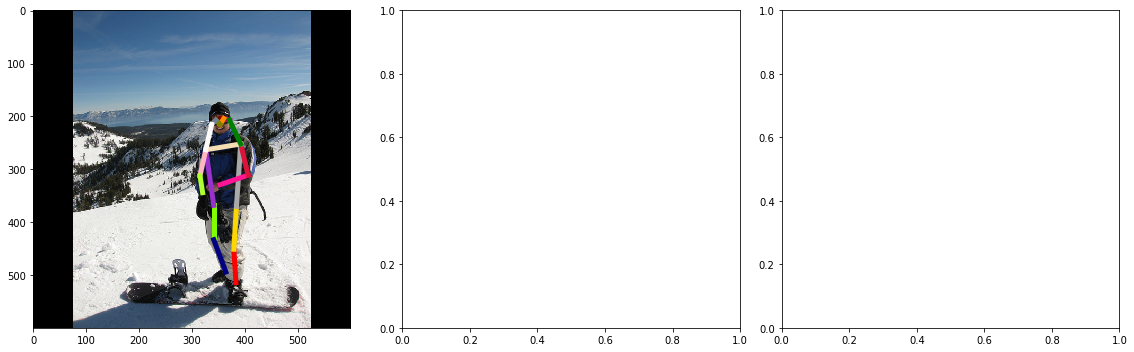

In [30]:
img_idx = 0
N_poses = len(pose_entries[img_idx])
n_rows = int(np.ceil(N_poses / 3))
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols)             
fig.set_size_inches(16,n_rows*5)
for i in range(N_poses):
    row, col = i // 3, i % 3
    title = f"Pose {i+1}"
    if(n_rows > 1):
        visualizations.draw_pose(np.array(imgs[img_idx,:]), [pose_entries[img_idx][i]], all_keypoints, ax=ax[row, col], title=title)
    else:
        visualizations.draw_pose(np.array(imgs[img_idx,:]), [pose_entries[img_idx][i]], all_keypoints, ax=ax[col], title=title)
plt.tight_layout()
plt.show()

# Loss

In [31]:
class PersonMSELoss(nn.Module):
    """
    Loss function used for training Top-down approaches (loss after human detector)
    """

    def __init__(self, use_target_weight=1):
        """
        Initializer of the loss module
        """

        super(PersonMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')
        self.use_target_weight = use_target_weight

        return


    def forward(self, output, target, target_weight=1):
        """
        Computing the average loss value accross all joints
        """

        batch_size = output.shape(0)
        num_joints = output.shape(1)
        heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
        loss = 0

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()
            loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        avg_loss = loss / num_joints

        return avg_loss


In [32]:
loss_function = PersonMSELoss()
# loss_value = loss_function(output=scaled_heats, target=None)

# Evaluation

In [33]:
metadata_ = metadata.copy()
metadata_["image_name"]  = [metadata["image_name"][1]]
metadata_["image_shape"]  = [metadata["image_shape"][1].numpy()]
print(metadata)

{'image_name': ['000000326128.jpg', '000000033638.jpg'], 'image_shape': tensor([[640, 480],
        [640, 425]]), 'bboxes': [[tensor([239.8200,  62.9100], dtype=torch.float64), tensor([184.5600, 243.5300], dtype=torch.float64), tensor([128.5800, 140.0100], dtype=torch.float64), tensor([408.8500, 265.8300], dtype=torch.float64)]]}


In [34]:
# computing predictions, loading previous results and appending new ones
utils.reset_predictions_file(test_exp)
cur_predictions = metrics.compute_predictions_hrnet(scaled_heats[:,:].cpu().numpy(), 
                                                    bboxes, metadata, cur_size=image_size)
utils.update_predictions_file(cur_predictions, test_exp)

In [35]:
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [36]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.835
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 
